## **Import Statements**

importing the required libraries


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm
import wget
import shutil

print("[+] Imported")

[+] Imported


## **Downloading Images**

creating function to download the images


In [2]:
def download_images(URL):
    CWD = os.getcwd()
    DATASET_DIR_NAME = "images"
    DATASET_DIR_PATH = os.path.join(CWD, DATASET_DIR_NAME)

    # creating folder
    try:
        os.mkdir(DATASET_DIR_PATH)
        print(f"[*] Dataset folder created in {DATASET_DIR_PATH}")
    except OSError:
        print("[*] Folder already exists")

    # downloading images
    try:
        FILENAME = wget.download(url=URL)
        print(f"[*] Downloaded {FILENAME}")
    except Exception:
        print(f"[*] Cannot Download")

    # moving downloaded images to folder
    IMAGE_EXT = ['.png', '.jpg', '.jpeg']
    for file in os.listdir(CWD):
        EXT = os.path.splitext(file)[1]
        if EXT not in IMAGE_EXT:
            continue
        else:
            FILEPATH = os.path.join(CWD, file)
            shutil.move(src=FILEPATH, dst=DATASET_DIR_PATH)

## **Creating Dataset**

converting images into n-dim arrays


In [70]:
def create_dataset(dst):
    IMAGES = os.listdir(dst)
    DATASET = []
    IMG_DIM = (256, 256)

    for image_name in tqdm(IMAGES, desc="Processing"):
        img_path = os.path.join(dst, image_name)
        img_arr = cv2.imread(filename=img_path, flags=0)
        img_arr = cv2.resize(img_arr, IMG_DIM)
        if len(img_arr) > 0:
            DATASET.append(np.array(img_arr))

    DATASET = np.array(DATASET)
    INFO_OBJ = {'rank': tf.rank(DATASET).numpy(), 'shape': DATASET.shape,
                'total_images': DATASET.shape[0], 'shape of each image': (DATASET.shape[1], DATASET.shape[2])}

    return (DATASET, INFO_OBJ)


In [71]:
IMAGES_DIR_PATH = os.path.join(os.getcwd(), "images")
dataset, info = create_dataset(dst=IMAGES_DIR_PATH)


Processing: 100%|██████████| 240/240 [00:00<00:00, 280.41it/s]


In [72]:
for key in info:
    print(key, ":", info[key])

rank : 3
shape : (240, 256, 256)
total_images : 240
shape of each image : (256, 256)


## **Splitting**

splitting our dataset into training and testing sets


In [73]:
def train_test_split(data_set, train_ratio=0.8, test_ratio=0.2, shuffle=True):
    if train_ratio + test_ratio == 1.0:
        SEED = 98
        # to select the same elements from the whole data set every time
        np.random.seed(seed=SEED)
        TOTAL_IMAGES = data_set.shape[0]
        TRAIN_SIZE = int(TOTAL_IMAGES * train_ratio)
        TEST_SIZE = int(TOTAL_IMAGES * test_ratio)
        RANDOM_INDICES = np.random.choice(
            TOTAL_IMAGES, size=TRAIN_SIZE, replace=False)

        # creating train and test sets
        TRAIN_SET = []
        TEST_SET = []
        for rand_index in RANDOM_INDICES:
            TRAIN_SET.append(data_set[rand_index])
        for index in range(0, TOTAL_IMAGES):
            if index not in RANDOM_INDICES:
                TEST_SET.append(data_set[index])
        TRAIN_SET = np.array(TRAIN_SET)
        TEST_SET = np.array(TEST_SET)

        # shuffle
        if shuffle:
            TRAIN_SET = tf.random.shuffle(TRAIN_SET).numpy()
            TEST_SET = tf.random.shuffle(TEST_SET).numpy()
        else:
            tf.random.set_seed(seed=SEED)
            TRAIN_SET = tf.random.shuffle(TRAIN_SET).numpy()
            TEST_SET = tf.random.shuffle(TEST_SET).numpy()

        return (TRAIN_SET, TEST_SET)
    else:
        print("[-] Invalid train-test ratio")


In [74]:
(train_images, test_images) = train_test_split(
    data_set=dataset, train_ratio=0.8, test_ratio=0.2, shuffle=True)


In [75]:
print("Shape of train set:", train_images.shape)
print("Shape of test set:", test_images.shape)

Shape of train set: (192, 256, 256)
Shape of test set: (48, 256, 256)


## **Helper Functions**

creating helper functions to use them later in this project


In [76]:
def pre_process(train_set, test_set):
    train_set = (np.expand_dims(train_set, axis=-1) / 255.0).astype(np.float32)
    test_set = (np.expand_dims(test_set, axis=-1) / 255.0).astype(np.float32)
    return (train_set, test_set)


def add_noise(data_set, noise_factor=0.07):
    MU = 0.0
    SIGMA = 1.0
    GAUSS = np.random.normal(MU, SIGMA, size=data_set.shape)
    data_set = data_set + noise_factor * GAUSS
    return np.clip(data_set, 0.0, 1.0)  # limiting the values between 0 and 1


def display_random_images(array1, array2):
    try:
        if array1.shape == array2.shape:
            N = 10
            plt.figure(figsize=(20, 5))
            RANDOM_INDICES = np.random.choice(array1.shape[0], N)
            for i in range(0, N):
                rand_index = RANDOM_INDICES[i]
                # top
                plt.subplot(2, N, i+1)
                plt.imshow(array1[rand_index])
                plt.gray()
                plt.grid(False)
                plt.xticks([])
                plt.yticks([])
                # bottom
                plt.subplot(2, N, i+1+N)
                plt.imshow(array2[rand_index])
                plt.gray()
                plt.grid(False)
                plt.xticks([])
                plt.yticks([])
            plt.show()
        else:
            print("[-] Invalid values | required arraylike")
    except Exception as err:
        print("[-] Error")
        print(err)


In [77]:
train_images, test_images = pre_process(train_images, test_images)

In [78]:
print("Shape of train images:", train_images.shape)
print("Shape of test images:", test_images.shape)

Shape of train images: (192, 256, 256, 1)
Shape of test images: (48, 256, 256, 1)


In [81]:
NOISE_FACTOR = 0.7
noisy_train_images = add_noise(train_images, NOISE_FACTOR)
noisy_test_images = add_noise(test_images, NOISE_FACTOR)

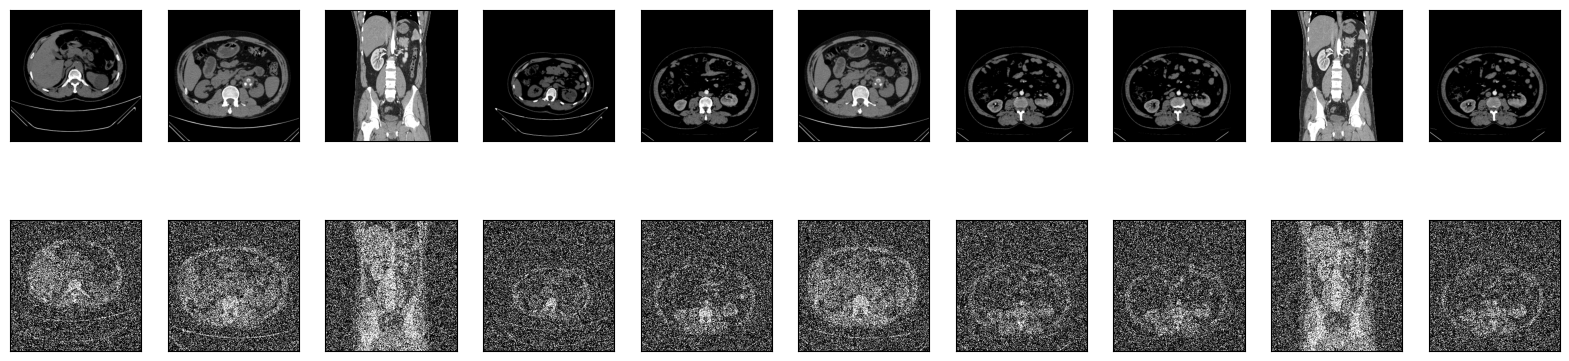

In [82]:
# look on images
display_random_images(train_images, noisy_train_images)

## **Model Building**

building our model using keras api


In [104]:
def build_model():
    model = tf.keras.Sequential([
        # Encoder
        tf.keras.layers.Conv2D(filters=64, kernel_size=(
            3, 3), padding="same", activation="relu", use_bias=True, name="CE1"),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(
            3, 3), padding="same", activation="relu", use_bias=True, name="CE2"),

        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same", name="ME1"),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(
            3, 3), padding="same", activation="relu", use_bias=True, name="CE3"),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(
            3, 3), padding="same", activation="relu", use_bias=True, name="CE4"),
        
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding="same", name="ME2"),
        
        # Decoder
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(
            3, 3), strides=2, padding="same", activation="relu", name="CDT1"),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(
            3, 3), padding="same", activation="relu", name="CD1"),

        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(
            3, 3), strides=2, padding="same", activation="relu", name="CDT2"),
            
        tf.keras.layers.Conv2D(filters=64, kernel_size=(
            3, 3), padding="same", activation="relu", name="CD2"),

        # Output
        tf.keras.layers.Conv2D(filters=1, kernel_size=(
            3, 3), padding="same", activation="sigmoid", name="Output")
    ])

    return model

In [105]:
model = build_model()

## **Summary**

getting summary of our model using `model.summary`


In [106]:
model.predict(train_images[[0]])
model.summary()

1/1 [==============================] - 1s 563ms/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CE1 (Conv2D)                (None, 256, 256, 64)      640       
                                                                 
 CE2 (Conv2D)                (None, 256, 256, 64)      36928     
                                                                 
 ME1 (MaxPooling2D)          (None, 128, 128, 64)      0         
                                                                 
 CE3 (Conv2D)                (None, 128, 128, 64)      36928     
                                                                 
 CE4 (Conv2D)                (None, 128, 128, 64)      36928     
                                                                 
 ME2 (MaxPooling2D)          (None, 64, 64, 64)        0         
                                                                 
 

## **Compiling**

compiling our model with loss, optimizer and metrics


In [107]:
LEARNING_RATE = 1e-1

OPTIMIZER = tf.optimizers.SGD(learning_rate=LEARNING_RATE)
LOSS = tf.losses.binary_crossentropy
METRICS = ['accuracy']

model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

## **Fitting**

using `model.fit` method to train our model


In [108]:
BATCH_SIZE = 10
EPOCHS = 20

HISTORY = model.fit(x=train_images,
                    y=train_images,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(test_images, test_images))


Epoch 1/20
20/20 [==============================] - 96s 5s/step - loss: 0.5185 - accuracy: 0.5950 - val_loss: 0.3980 - val_accuracy: 0.6348
Epoch 2/20
20/20 [==============================] - 96s 5s/step - loss: 0.4260 - accuracy: 0.5985 - val_loss: 0.3964 - val_accuracy: 0.6348
Epoch 3/20
20/20 [==============================] - 94s 5s/step - loss: 0.4246 - accuracy: 0.5985 - val_loss: 0.3939 - val_accuracy: 0.6348
Epoch 4/20
20/20 [==============================] - 93s 5s/step - loss: 0.4209 - accuracy: 0.5985 - val_loss: 0.3871 - val_accuracy: 0.6348
Epoch 5/20
20/20 [==============================] - 93s 5s/step - loss: 0.3974 - accuracy: 0.5985 - val_loss: 0.3327 - val_accuracy: 0.6348
Epoch 6/20
20/20 [==============================] - 93s 5s/step - loss: 0.2950 - accuracy: 0.6055 - val_loss: 0.2374 - val_accuracy: 0.6501
Epoch 7/20
20/20 [==============================] - 77s 4s/step - loss: 0.2484 - accuracy: 0.6183 - val_loss: 0.2287 - val_accuracy: 0.6505
Epoch 8/20
20/20 [==

## **Visualisation**

creating function to plot the graphs


In [109]:
def plotter(x, y, c, s):
    plt.plot(x, y, color=c)
    plt.title(s)
    plt.show()


def plot_history_graphs(epochs, HIST):
    TRAIN_LOSS = HIST.history['loss']
    VALIDATION_LOSS = HIST.history['val_loss']
    TRAIN_ACCURACY = HIST.history['accuracy']
    VALIDATION_ACCURACY = HIST.history['val_accuracy']
    X_TICKS = np.arange(1, epochs + 1)

    plotter(X_TICKS, TRAIN_LOSS, 'r', 'Train Loss')
    plotter(X_TICKS, VALIDATION_LOSS, 'g', 'Validation Loss')
    plotter(X_TICKS, TRAIN_ACCURACY, 'b', 'Train Accuracy')
    plotter(X_TICKS, VALIDATION_ACCURACY, 'y', 'Validation Accuracy')

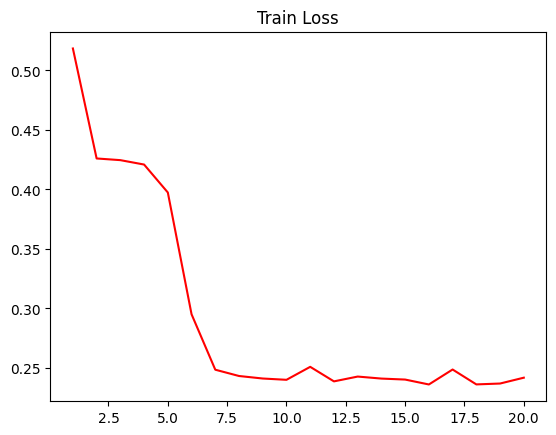

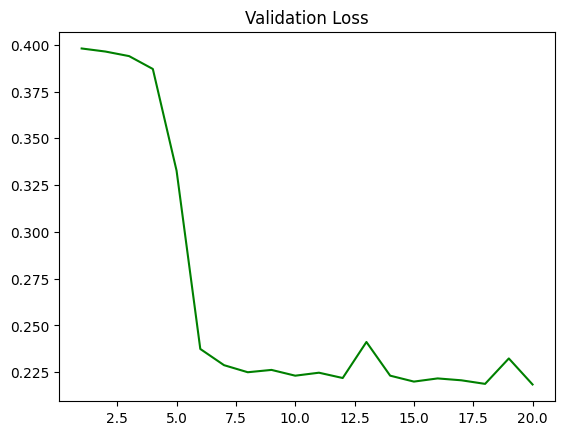

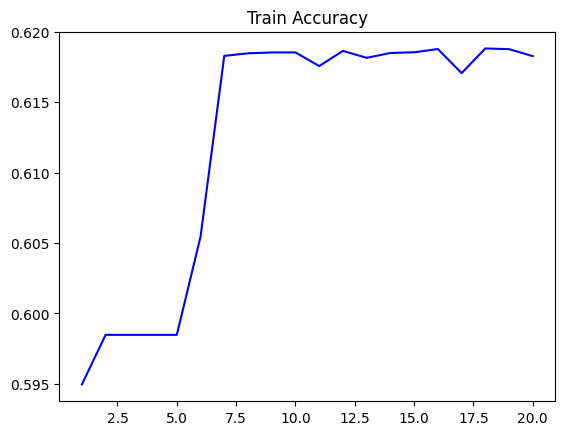

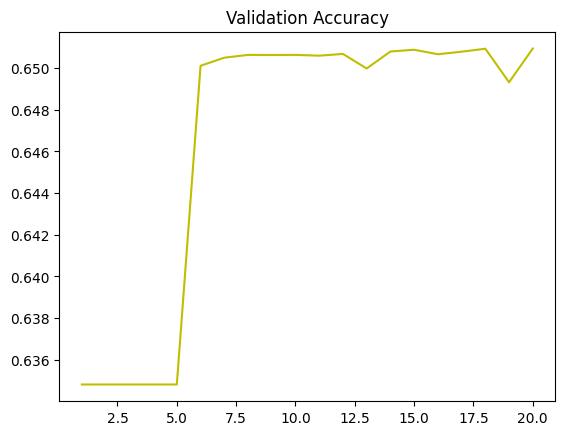

In [110]:
plot_history_graphs(EPOCHS, HISTORY)


## **Predictions**

making predictions using our trained model


In [111]:
predictions = model.predict(test_images)


2/2 [==============================] - 3s 1s/step


In [112]:
print("Shape of predictions:", predictions.shape)


Shape of predictions: (48, 256, 256, 1)


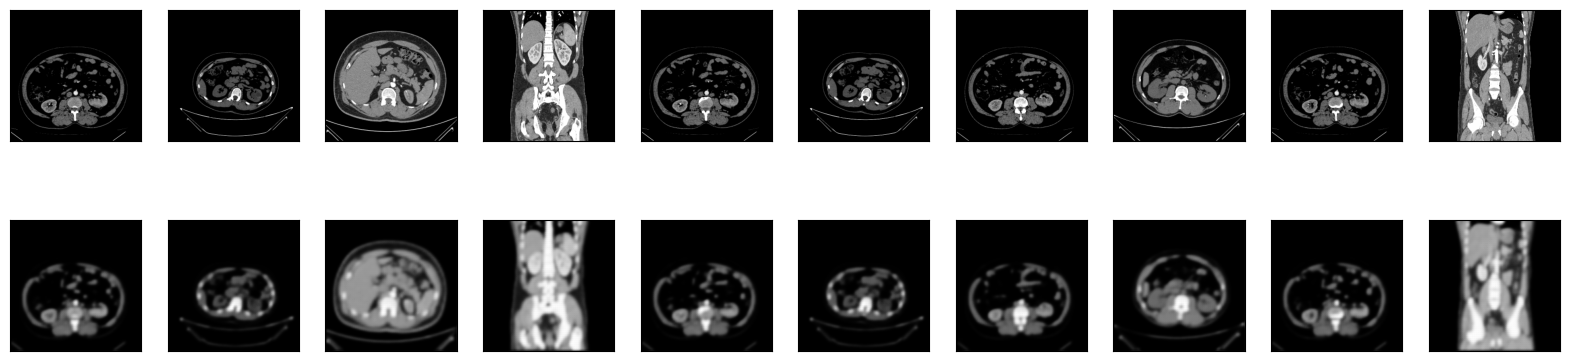

In [113]:
display_random_images(test_images, predictions)


## **Actual Training**

training our model with noisy images


In [114]:
HISTORY = model.fit(x=noisy_train_images,
                    y=train_images,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=(noisy_test_images, test_images))


Epoch 1/20
20/20 [==============================] - 78s 4s/step - loss: 0.4053 - accuracy: 0.6020 - val_loss: 0.4576 - val_accuracy: 0.6457
Epoch 2/20
20/20 [==============================] - 78s 4s/step - loss: 0.3631 - accuracy: 0.6058 - val_loss: 0.2762 - val_accuracy: 0.6360
Epoch 3/20
20/20 [==============================] - 82s 4s/step - loss: 0.2994 - accuracy: 0.6124 - val_loss: 0.2403 - val_accuracy: 0.6500
Epoch 4/20
20/20 [==============================] - 83s 4s/step - loss: 0.2821 - accuracy: 0.6164 - val_loss: 0.2603 - val_accuracy: 0.6477
Epoch 5/20
20/20 [==============================] - 83s 4s/step - loss: 0.2576 - accuracy: 0.6180 - val_loss: 0.2370 - val_accuracy: 0.6506
Epoch 6/20
20/20 [==============================] - 82s 4s/step - loss: 0.2530 - accuracy: 0.6184 - val_loss: 0.2382 - val_accuracy: 0.6506
Epoch 7/20
20/20 [==============================] - 78s 4s/step - loss: 0.2668 - accuracy: 0.6175 - val_loss: 0.2362 - val_accuracy: 0.6505
Epoch 8/20
20/20 [==

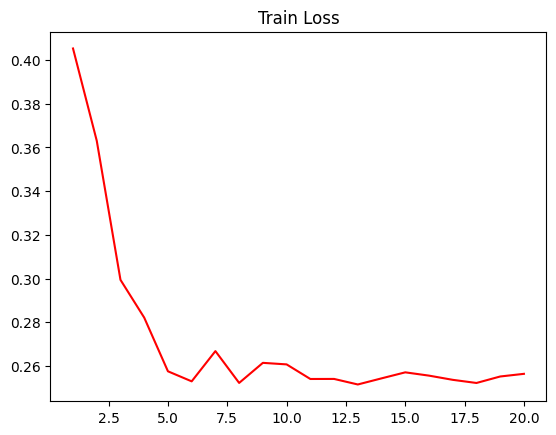

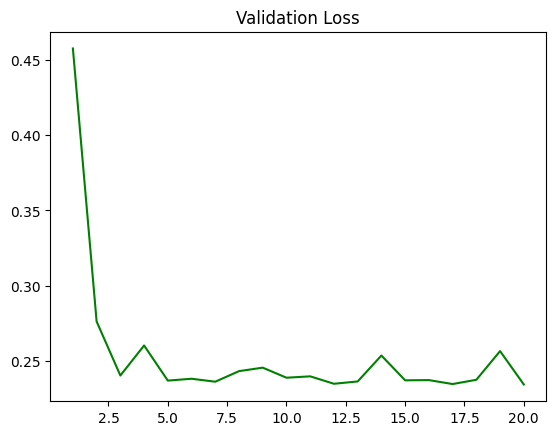

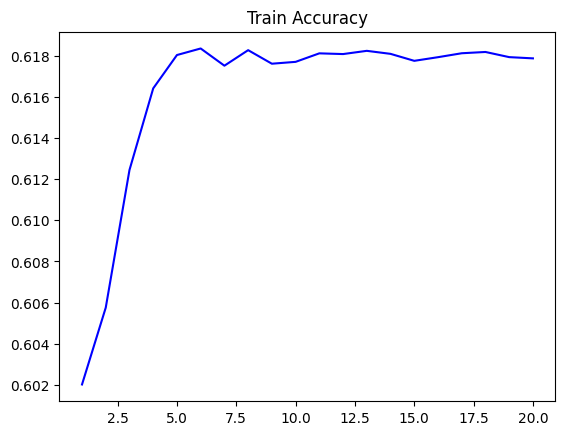

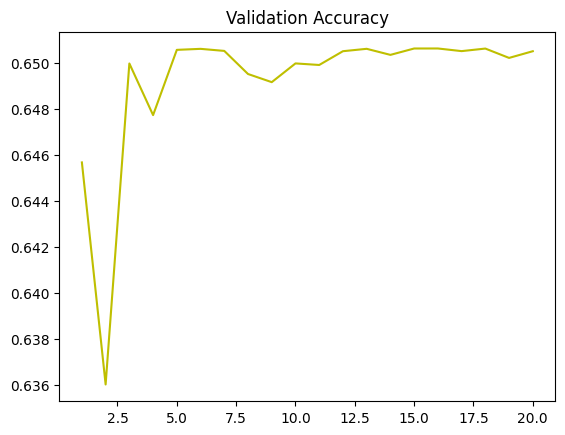

In [115]:
plot_history_graphs(EPOCHS, HISTORY)


In [116]:
predictions = model.predict(noisy_test_images)


2/2 [==============================] - 3s 1s/step


In [117]:
print("Shape of predictions:", predictions.shape)


Shape of predictions: (48, 256, 256, 1)


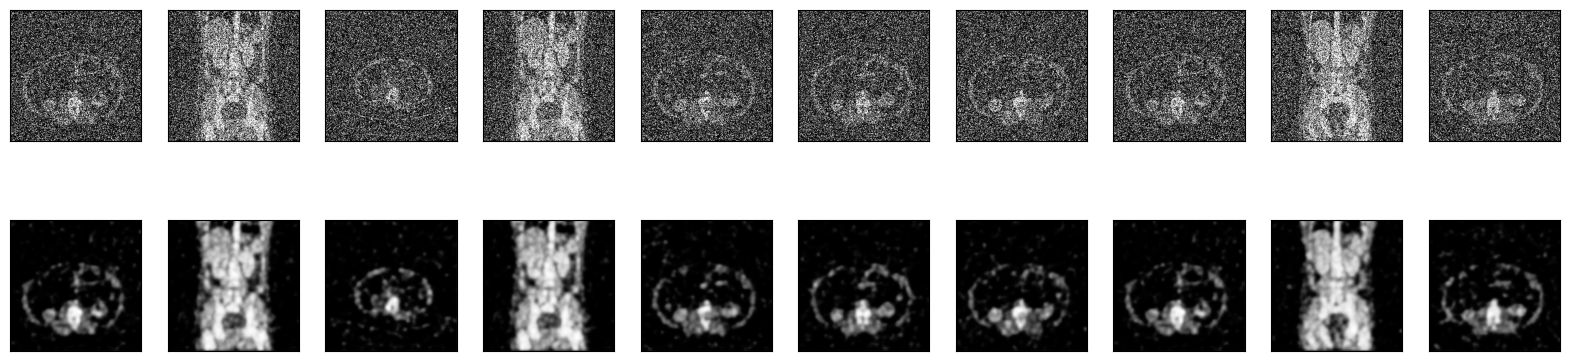

In [118]:
display_random_images(noisy_test_images, predictions)
